# Instalasi & Import

In [1]:
# Cell 1: Install & Import
# Instalasi library yang diperlukan
!pip install -q xgboost optuna shap

import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel

from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
from optuna.pruners import SuccessiveHalvingPruner, MedianPruner
from xgboost.callback import TrainingCallback

# Konfigurasi Lingkungan
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
pio.renderers.default = "iframe" # Agar grafik interaktif muncul di Kaggle

print("✅ Setup Selesai.")
print(f"🔹 XGBoost Version: {xgb.__version__} (Target: v3.0+)")
print(f"🔹 Optuna Version: {optuna.__version__}")
print(f"🔹 GPU Status: {'Aktif (CUDA)' if xgb.build_info()['USE_CUDA'] else 'Tidak Terdeteksi!'}")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


✅ Setup Selesai.
🔹 XGBoost Version: 3.1.0 (Target: v3.0+)
🔹 Optuna Version: 2.10.1
🔹 GPU Status: Aktif (CUDA)


# Load Dataset (Otomatis)

In [2]:
# Cell 2: Load Data
print("📂 Mencari file dataset di /kaggle/input/ ...")

train_path = None
test_path = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if "training" in filename.lower() and "csv" in filename:
            train_path = full_path
        elif "testing" in filename.lower() and "csv" in filename:
            test_path = full_path

if train_path and test_path:
    print(f"✅ Training Data: {train_path}")
    print(f"✅ Testing Data: {test_path}")
    
    # Load Data Asli
    df_train_full = pd.read_csv(train_path)
    df_test_raw = pd.read_csv(test_path)
    
    print(f"🔹 Shape Train Awal: {df_train_full.shape}")
    print(f"🔹 Shape Test Awal:  {df_test_raw.shape}")
else:
    raise FileNotFoundError("❌ File dataset UNSW-NB15 tidak ditemukan! Pastikan sudah Add Input.")

📂 Mencari file dataset di /kaggle/input/ ...
✅ Training Data: /kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
✅ Testing Data: /kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
🔹 Shape Train Awal: (175341, 45)
🔹 Shape Test Awal:  (82332, 45)


# Preprocessing & Class Weights

In [3]:
# Cell 3: Preprocessing (FULL FEATURES - BERSIH & EFISIEN)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# 1. Bersihkan Kolom Sampah
# Kita hanya menghapus 'id' karena kolom IP/Waktu sudah tidak ada di dataset ini.
drop_cols = ['id'] 
df_train_full = df_train_full.drop(columns=drop_cols, errors='ignore')
df_test_raw = df_test_raw.drop(columns=drop_cols, errors='ignore')

# 2. Pisahkan Fitur & Target
X_raw = df_train_full.drop(columns=['attack_cat', 'label'])
y_raw = df_train_full['attack_cat']

X_test_final_raw = df_test_raw.drop(columns=['attack_cat', 'label'])
y_test_final_raw = df_test_raw['attack_cat']

# 3. Encoding Kategorikal
cat_cols = X_raw.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    # Gabung train & test sebentar agar LabelEncoder tahu semua variasi data
    full_col = pd.concat([X_raw[col], X_test_final_raw[col]], axis=0).astype(str)
    le.fit(full_col)
    
    X_raw[col] = le.transform(X_raw[col].astype(str))
    X_test_final_raw[col] = le.transform(X_test_final_raw[col].astype(str))

# 4. Encoding Target
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
y_test_final = le_target.transform(y_test_final_raw)

# 5. Scaling (Standarisasi)
scaler = StandardScaler()
X_enc = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_final_raw), columns=X_test_final_raw.columns)

# 6. Optimasi Memori (Float32) - Agar ringan di GPU
float_cols = X_enc.select_dtypes(include=['float64']).columns
X_enc[float_cols] = X_enc[float_cols].astype('float32')
X_test_enc[float_cols] = X_test_enc[float_cols].astype('float32')

# --- BYPASS FEATURE SELECTION ---
print("\n⏩ MELEWATI Feature Selection (Menggunakan Full Dataset)...")

# Langsung gunakan semua data hasil preprocessing
X_selected = X_enc
X_test_selected = X_test_enc

print(f"✅ Dataset Siap.")
print(f"🔹 Jumlah Fitur Final: {X_selected.shape[1]} (Full Set)")

# 7. Splitting (Train/Val)
# stratify=y memastikan proporsi serangan langka (Worms) tetap terjaga di Val set
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Soft Class Weighting (Strategi Penyeimbang Data)
raw_weights = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_train = np.sqrt(raw_weights)

print(f"🔹 Train Set: {X_train.shape}")
print(f"🔹 Val Set:   {X_val.shape}")


⏩ MELEWATI Feature Selection (Menggunakan Full Dataset)...
✅ Dataset Siap.
🔹 Jumlah Fitur Final: 42 (Full Set)
🔹 Train Set: (140272, 42)
🔹 Val Set:   (35069, 42)


# Definisi Objective Function (Generic)

In [4]:
# Cell 4: Objective Function (Tuning Space Dilonggarkan)

class OptunaPruningCallback(TrainingCallback):
    def __init__(self, trial, metric_name):
        self.trial = trial
        self.metric_name = metric_name
        
    def after_iteration(self, model, epoch, evals_log):
        if not evals_log: return False
        score = evals_log['validation_0'][self.metric_name][-1]
        self.trial.report(score, epoch)
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        return False

def objective_xgboost(trial):
    # --- PERUBAHAN 3: HYPERPARAMETER SPACE DISESUAIKAN ---
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000), # Tambah pohon
        'max_depth': trial.suggest_int('max_depth', 6, 15), # Izinkan pohon lebih dalam
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # Kurangi batas regularisasi agar model mau belajar kelas sulit
        'gamma': trial.suggest_float('gamma', 0, 2), # Dulu 0-5, sekarang diperkecil
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5), # Perkecil agar sensitif
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 0.1, log=True),
        
        # Fixed
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'mlogloss',
        'verbosity': 0
    }

    pruning_callback = OptunaPruningCallback(trial, "mlogloss")

    model = xgb.XGBClassifier(**param, random_state=42, callbacks=[pruning_callback])
    
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights_train, # Pakai Soft Weights
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    
    return f1

# Strategi 1 - Optuna TPE (Tree-structured Parzen Estimator)

In [5]:
# Cell 5: Optimasi TPE (Bayesian)
print("🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...")
start_time = time.time()

study_tpe = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study_tpe.optimize(objective_xgboost, n_trials=30) # 30 Trial
time_tpe = time.time() - start_time

print(f"✅ TPE Selesai dalam: {time_tpe:.2f} detik.")
print(f"🏆 Best F1 TPE: {study_tpe.best_value:.4f}")

[I 2025-12-30 20:00:03,147] A new study created in memory with name: no-name-27da00da-cccb-4b9d-ab51-23a4d4c41fb9


🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...


[I 2025-12-30 20:01:14,828] Trial 0 finished with value: 0.6458218888182928 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6458218888182928.
[I 2025-12-30 20:01:52,985] Trial 1 finished with value: 0.6489738345528074 and parameters: {'n_estimators': 3124, 'max_depth': 6, 'learning_rate': 0.18276027831785724, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.36364993441420124, 'min_child_weight': 1, 'reg_alpha': 1.348018029089077e-06, 'reg_lambda': 4.712973756110775e-05}. Best is trial 1 with value: 0.6489738345528074.
[I 2025-12-30 20:02:40,797] Trial 2 finished with value: 0.6571650065414163 and parameters: {'n_estimators': 2296, 'max_depth': 8, 'learning_rate': 0.0625228791640621

✅ TPE Selesai dalam: 1647.82 detik.
🏆 Best F1 TPE: 0.6718


# Strategi 2 - Optuna ASHA (Asynchronous Successive Halving)

In [6]:
# Cell 6: Optimasi ASHA (Pruning Agresif)
print("🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...")
start_time = time.time()

# ASHA di Optuna diatur lewat Pruner
study_asha = optuna.create_study(
    direction='maximize',
    sampler=RandomSampler(seed=42), # Sampler random agar eksplorasi luas
    pruner=SuccessiveHalvingPruner(min_resource=100, reduction_factor=3)
)

study_asha.optimize(objective_xgboost, n_trials=30)
time_asha = time.time() - start_time

print(f"✅ ASHA Selesai dalam: {time_asha:.2f} detik.")
print(f"🏆 Best F1 ASHA: {study_asha.best_value:.4f}")

[I 2025-12-30 20:27:30,972] A new study created in memory with name: no-name-f3be6335-8ea6-4a12-ae80-8689d587e9cc


🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...


[I 2025-12-30 20:28:42,078] Trial 0 finished with value: 0.6458218888182928 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6458218888182928.
[I 2025-12-30 20:28:48,150] Trial 1 pruned. 
[I 2025-12-30 20:28:57,224] Trial 2 pruned. 
[I 2025-12-30 20:29:41,666] Trial 3 pruned. 
[I 2025-12-30 20:29:44,262] Trial 4 pruned. 
[I 2025-12-30 20:29:51,590] Trial 5 pruned. 
[I 2025-12-30 20:30:44,215] Trial 6 pruned. 
[I 2025-12-30 20:30:47,902] Trial 7 pruned. 
[I 2025-12-30 20:30:55,928] Trial 8 pruned. 
[I 2025-12-30 20:31:22,811] Trial 9 pruned. 
[I 2025-12-30 20:31:27,554] Trial 10 pruned. 
[I 2025-12-30 20:31:30,092] Trial 11 pruned. 
[I 2025-12-30 20:31:36,982] Trial 12 pruned. 
[I 2025-12-30 20:31:44,395] Trial 13 pru

✅ ASHA Selesai dalam: 462.31 detik.
🏆 Best F1 ASHA: 0.6630


# Strategi 3 - Optuna NSGA-II (Genetic Algorithm)

In [7]:
# Cell 7: Optimasi NSGA-II (Evolutionary Algorithm)
print("🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...")
start_time = time.time()

study_nsga = optuna.create_study(
    direction='maximize',
    sampler=NSGAIISampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study_nsga.optimize(objective_xgboost, n_trials=30)
time_nsga = time.time() - start_time

print(f"✅ NSGA-II Selesai dalam: {time_nsga:.2f} detik.")
print(f"🏆 Best F1 NSGA-II: {study_nsga.best_value:.4f}")

[I 2025-12-30 20:35:13,324] A new study created in memory with name: no-name-6bc310c9-a8c0-40b9-8dec-bc000b5de40b


🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...


[I 2025-12-30 20:36:24,522] Trial 0 finished with value: 0.6458218888182928 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6458218888182928.
[I 2025-12-30 20:37:02,656] Trial 1 finished with value: 0.6489738345528074 and parameters: {'n_estimators': 3124, 'max_depth': 6, 'learning_rate': 0.18276027831785724, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.36364993441420124, 'min_child_weight': 1, 'reg_alpha': 1.348018029089077e-06, 'reg_lambda': 4.712973756110775e-05}. Best is trial 1 with value: 0.6489738345528074.
[I 2025-12-30 20:37:50,409] Trial 2 finished with value: 0.6571650065414163 and parameters: {'n_estimators': 2296, 'max_depth': 8, 'learning_rate': 0.0625228791640621

✅ NSGA-II Selesai dalam: 1494.58 detik.
🏆 Best F1 NSGA-II: 0.6711


# Evaluasi Model Final & Komparasi

In [8]:
# Cell 8: Training Final & Evaluasi (Update Soft Weights)

def train_evaluate_final(study, method_name):
    print(f"⚙️ Melatih Model Final ({method_name})...")
    
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'verbosity': 0
    })
    
    # HITUNG BOBOT FINAL (FULL DATA) DENGAN SQRT JUGA
    raw_full_weights = compute_sample_weight(class_weight='balanced', y=y)
    soft_full_weights = np.sqrt(raw_full_weights) # <--- PENTING: Pakai SQRT di sini juga
    
    # Train di FULL DATA
    model = xgb.XGBClassifier(**best_params, random_state=42)
    model.fit(X_selected, y, sample_weight=soft_full_weights)
    
    preds = model.predict(X_test_selected)
    
    return model, preds

# Eksekusi ulang
model_tpe, preds_tpe = train_evaluate_final(study_tpe, "TPE")
model_asha, preds_asha = train_evaluate_final(study_asha, "ASHA")
model_nsga, preds_nsga = train_evaluate_final(study_nsga, "NSGA-II")

# Rekap Hasil
def get_metrics(y_true, y_pred, time_taken, study):
    return {
        'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
        'Waktu Optimasi (s)': time_taken,
        'Best Trial Ke-': study.best_trial.number
    }

results = pd.DataFrame([
    get_metrics(y_test_final, preds_tpe, time_tpe, study_tpe),
    get_metrics(y_test_final, preds_asha, time_asha, study_asha),
    get_metrics(y_test_final, preds_nsga, time_nsga, study_nsga)
], index=['TPE', 'ASHA', 'NSGA-II'])

print("\n=== HASIL AKHIR KOMPARASI (DATA TESTING) ===")
display(results)

# Detail Report TPE (Contoh)
print("\n--- Detailed Classification Report (Metode TPE) ---")
print(classification_report(y_test_final, preds_tpe, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode ASHA) ---")
print(classification_report(y_test_final, preds_asha, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode NSGA-II) ---")
print(classification_report(y_test_final, preds_nsga, target_names=le_target.classes_))

⚙️ Melatih Model Final (TPE)...
⚙️ Melatih Model Final (ASHA)...
⚙️ Melatih Model Final (NSGA-II)...

=== HASIL AKHIR KOMPARASI (DATA TESTING) ===


,F1-Score (Macro),Accuracy,Precision (Macro),Recall (Macro),Waktu Optimasi (s),Best Trial Ke-
TPE,0.535824,0.726364,0.519548,0.628594,1647.818460,27
ASHA,0.530274,0.720813,0.515731,0.623455,462.306104,23
NSGA-II,0.534301,0.726449,0.518070,0.624775,1494.579550,25



--- Detailed Classification Report (Metode TPE) ---
                precision    recall  f1-score   support

      Analysis       0.06      0.23      0.10       677
      Backdoor       0.03      0.14      0.05       583
           DoS       0.37      0.42      0.39      4089
      Exploits       0.74      0.67      0.71     11132
       Fuzzers       0.28      0.63      0.38      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.98      0.67      0.80     37000
Reconnaissance       0.90      0.83      0.86      3496
     Shellcode       0.27      0.93      0.42       378
         Worms       0.57      0.80      0.67        44

      accuracy                           0.73     82332
     macro avg       0.52      0.63      0.54     82332
  weighted avg       0.85      0.73      0.77     82332


--- Detailed Classification Report (Metode ASHA) ---
                precision    recall  f1-score   support

      Analysis       0.05      0.21      0.08    

# Riwayat Optimasi

In [ ]:
import pandas as pd
import optuna

# Daftar studi yang akan dianalisis
# Format: (Nama Tampilan, Objek Study)
studies_to_analyze = [
    ("TPE (Bayesian)", study_tpe),
    ("ASHA (Pruning)", study_asha),
    ("NSGA-II (Evolutionary)", study_nsga)
]

print("📊 === REKAPITULASI HASIL OPTIMASI ===\n")

for name, study in studies_to_analyze:
    print(f"\n{'='*60}")
    print(f"🔍 ANALISIS METODE: {name}")
    print(f"{'='*60}")
    
    try:
        # 1. Cek apakah study punya hasil?
        if len(study.trials) == 0:
            print("⚠️ Belum ada trial yang dijalankan.")
            continue

        # 2. Ambil Trial Terbaik
        best_trial = study.best_trial
        
        print(f"🏆 SKOR TERBAIK (Macro F1): {best_trial.value:.6f}")
        print(f"🔢 Ditemukan pada Trial Nomor : {best_trial.number}")
        
        # Cek durasi trial terbaik (jika tercatat)
        if best_trial.duration:
            duration_sec = best_trial.duration.total_seconds()
            print(f"⏱️  Durasi Trial Tersebut    : {duration_sec:.2f} detik")
        
        # 3. Tampilkan Parameter Terbaik
        print("\n⚙️  KOMBINASI PARAMETER TERBAIK:")
        for key, value in best_trial.params.items():
            print(f"   • {key.ljust(20)} : {value}")

        # 4. Buat DataFrame & Tampilkan 5 Terbaik
        df_results = study.trials_dataframe()
        
        # Filter kolom agar tidak terlalu lebar saat ditampilkan
        # Kita ambil kolom: number, value, state, duration, dan semua params_*
        cols_to_show = ['number', 'value', 'state', 'duration']
        cols_params = [c for c in df_results.columns if c.startswith('params_')]
        final_cols = cols_to_show + cols_params
        
        # Sortir dari nilai tertinggi (Descending)
        df_top = df_results.sort_values(by='value', ascending=False).head(5)
        
        print(f"\n📋 TOP 5 PERCOBAAN ({name}):")
        # Menggunakan display() agar format tabel pandas muncul rapi di Notebook
        display(df_top[final_cols])
        
        # 5. Simpan ke CSV untuk Lampiran Skripsi
        # Nama file: hasil_tpe.csv, hasil_asha.csv, dll.
        filename = f"hasil_optimasi_{name.split()[0].lower()}.csv"
        df_results.to_csv(filename, index=False)
        print(f"💾 File CSV tersimpan: {filename}")
        
    except ValueError:
        print("⚠️ Error: Mungkin tidak ada trial yang berhasil (semua Pruned/Gagal).")
    except Exception as e:
        print(f"⚠️ Terjadi kesalahan: {e}")

print("\n✅ Selesai. Semua data siap dianalisis untuk Bab 4.")

# Visualisasi Analisis Data & Penanganan Imbalance

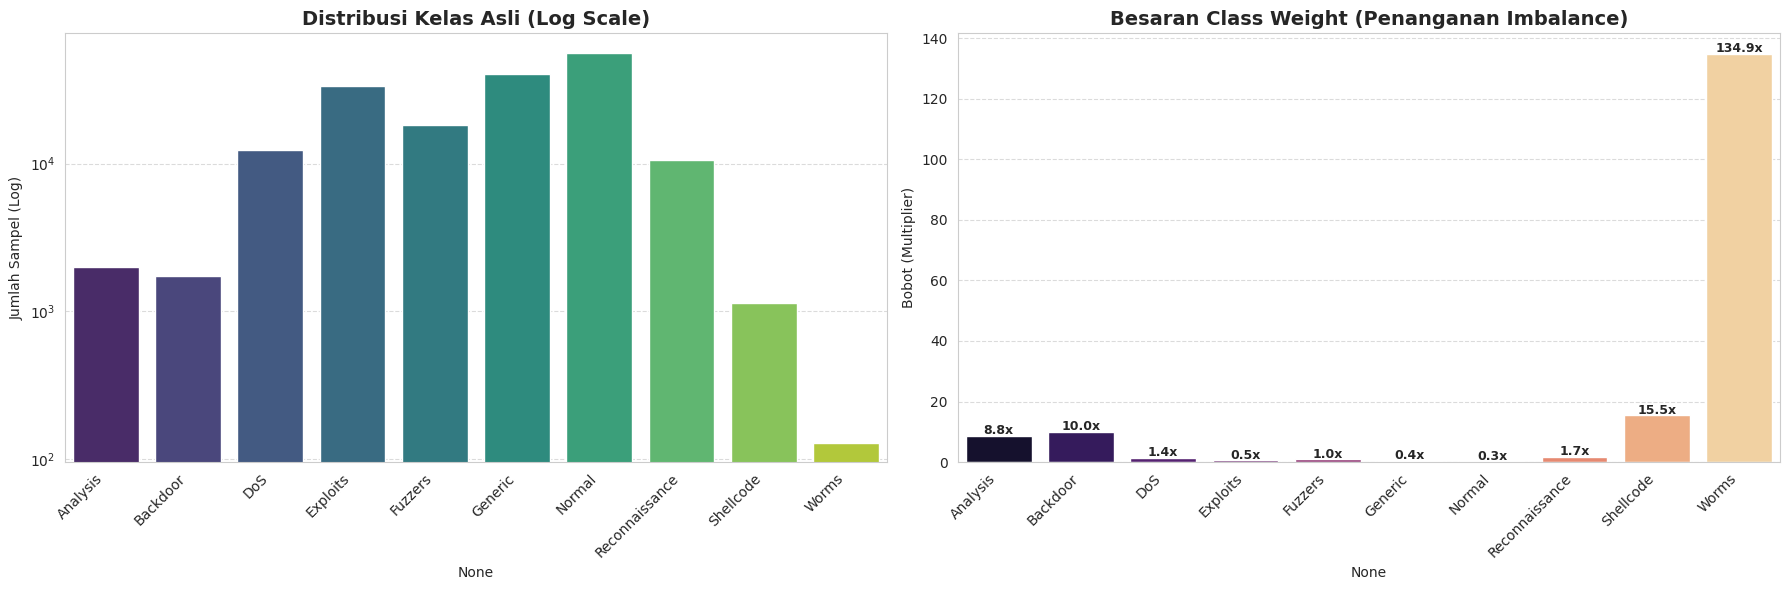

In [9]:
# Cell Tambahan 1: Visualisasi Distribusi Data vs Bobot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Siapkan Data
class_counts = pd.Series(y).value_counts().sort_index()
class_names = le_target.classes_

# Ambil bobot unik per kelas (karena sample_weight dihitung per baris, kita ambil 1 perwakilan per kelas)
unique_weights = {}
for cls_idx, cls_name in enumerate(class_names):
    # Cari indeks pertama dimana kelas ini muncul
    idx = np.where(y == cls_idx)[0][0]
    unique_weights[cls_name] = compute_sample_weight('balanced', y)[idx]

weights_series = pd.Series(unique_weights).sort_index()

# 2. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Distribusi Jumlah Data Asli (Log Scale agar kelas minoritas terlihat)
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Distribusi Kelas Asli (Log Scale)", fontsize=14, fontweight='bold')
axes[0].set_yscale("log") # PENTING: Pakai Log Scale
axes[0].set_ylabel("Jumlah Sampel (Log)")
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot B: Bobot yang Diberikan (Class Weights)
sns.barplot(x=weights_series.index, y=weights_series.values, ax=axes[1], palette="magma")
axes[1].set_title("Besaran Class Weight (Penanganan Imbalance)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Bobot (Multiplier)")
axes[1].set_xticklabels(weights_series.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi
for i, v in enumerate(weights_series.values):
    axes[1].text(i, v + 0.5, f"{v:.1f}x", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualisasi 3 Perbandingan Kecepatan Optimasi (TPE vs ASHA vs NSGA-II)

In [11]:
# Cell Tambahan 3: Grafik Konvergensi Komparatif
import plotly.graph_objects as go

# Fungsi helper untuk ekstrak history
def get_optimization_history(study):
    df = study.trials_dataframe()
    # Hanya ambil trial yang COMPLETE (bukan pruned)
    df_success = df[df.state == 'COMPLETE'].sort_values(by='number')
    # Hitung best value kumulatif (running maximum)
    df_success['best_value'] = df_success['value'].cummax()
    return df_success

df_tpe = get_optimization_history(study_tpe)
df_asha = get_optimization_history(study_asha)
df_nsga = get_optimization_history(study_nsga)

# Plotting Interactive Line Chart
fig = go.Figure()

# Garis TPE
fig.add_trace(go.Scatter(
    x=df_tpe['number'], y=df_tpe['best_value'],
    mode='lines+markers', name='TPE (Bayesian)',
    line=dict(color='blue', width=2)
))

# Garis ASHA
fig.add_trace(go.Scatter(
    x=df_asha['number'], y=df_asha['best_value'],
    mode='lines+markers', name='ASHA (Pruning)',
    line=dict(color='green', width=2, dash='dot') # Putus-putus biar beda
))

# Garis NSGA-II
fig.add_trace(go.Scatter(
    x=df_nsga['number'], y=df_nsga['best_value'],
    mode='lines+markers', name='NSGA-II (Evolutionary)',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title='<b>Dinamika Optimasi Hiperparameter</b>: Seberapa Cepat Menemukan F1 Terbaik?',
    xaxis_title='Jumlah Trial (Iterasi)',
    yaxis_title='Best F1-Score (Validation)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99)
)
fig.show()

# Visualisasi 4 Evaluasi Performa Akhir (Confusion Matrix)

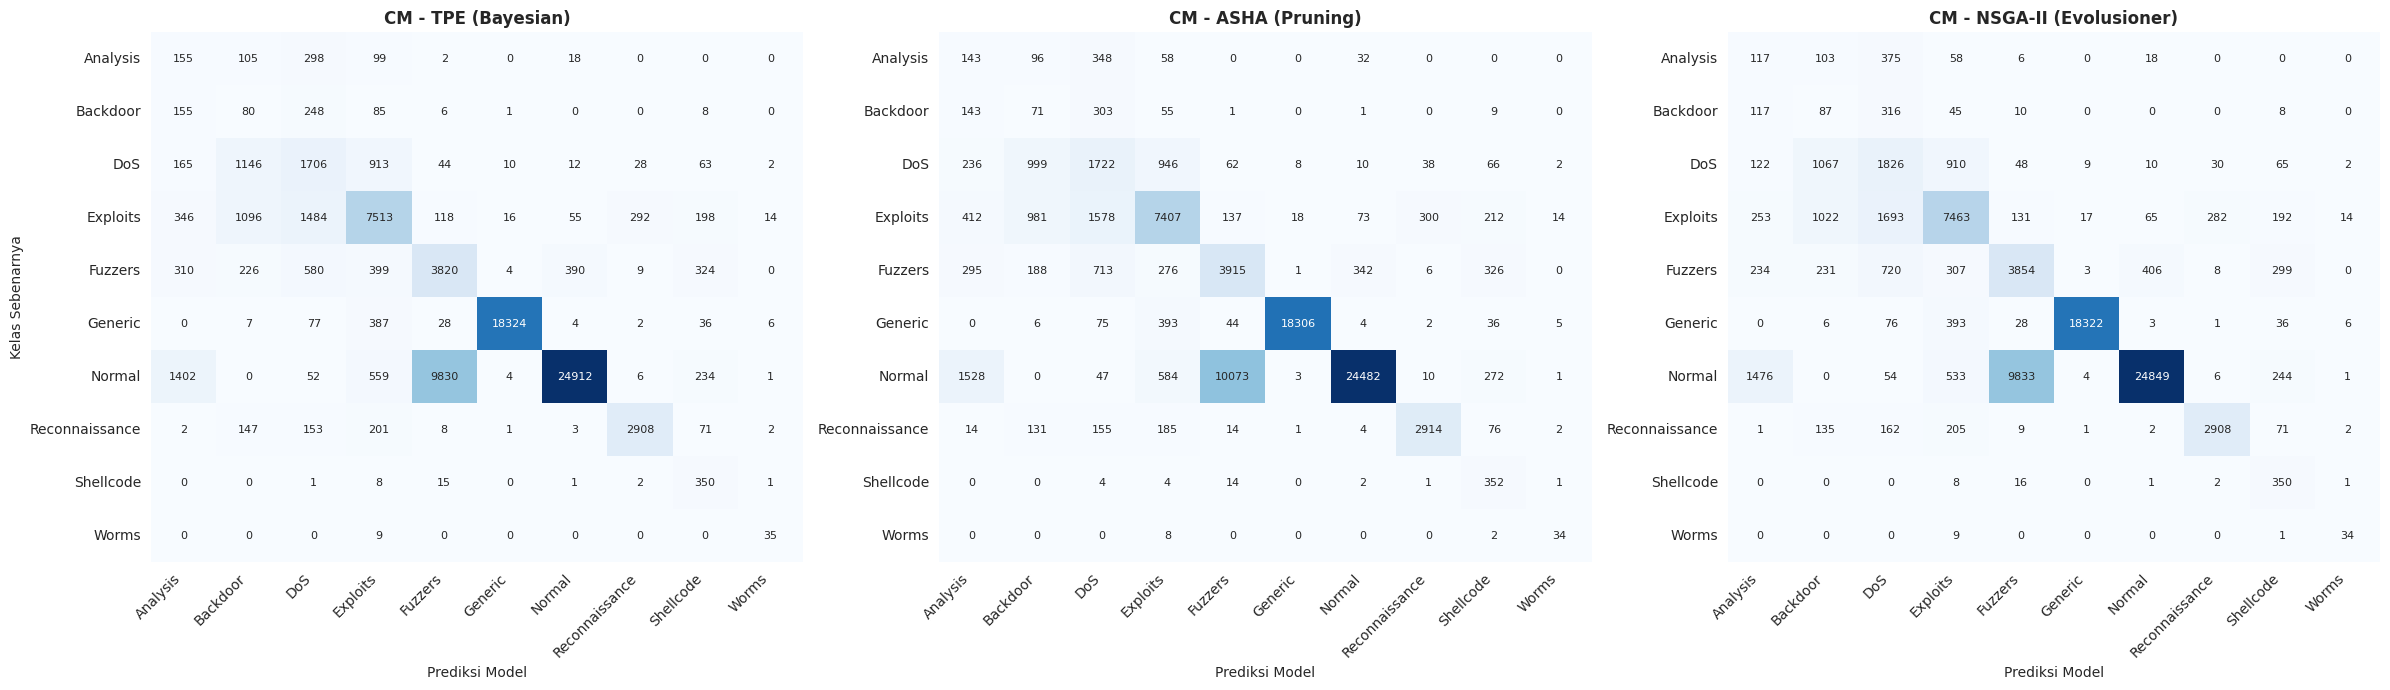

In [13]:
# Cell Tambahan 4: Confusion Matrix Komparatif
def plot_cm_custom(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    # Normalisasi agar warnanya berdasarkan persentase kebenaran per kelas
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                annot_kws={"size": 8}) # Font kecil biar muat
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('Prediksi Model')
    ax.set_xticklabels(le_target.classes_, rotation=45, ha='right')

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

plot_cm_custom(y_test_final, preds_tpe, "CM - TPE (Bayesian)", axes[0])
plot_cm_custom(y_test_final, preds_asha, "CM - ASHA (Pruning)", axes[1])
plot_cm_custom(y_test_final, preds_nsga, "CM - NSGA-II (Evolusioner)", axes[2])

axes[0].set_ylabel('Kelas Sebenarnya')
plt.tight_layout()
plt.show()

In [14]:
# Cell Tambahan: Visualisasi Riwayat Optimasi (Convergence Plot)
from optuna.visualization import plot_optimization_history
import plotly.io as pio

# Agar grafik muncul di Kaggle/Colab
pio.renderers.default = "iframe"

print("📊 Menampilkan Grafik Konvergensi (Optimization History)...")

# 1. Grafik TPE
print("\n=== Riwayat Optimasi TPE ===")
try:
    fig_tpe = plot_optimization_history(study_tpe)
    fig_tpe.update_layout(
        title="Optimization History - TPE",
        template="plotly_white",
        height=500
    )
    fig_tpe.show()
except Exception as e:
    print(f"⚠️ Gagal memplot TPE: {e}")

# 2. Grafik ASHA
print("\n=== Riwayat Optimasi ASHA ===")
try:
    fig_asha = plot_optimization_history(study_asha)
    fig_asha.update_layout(
        title="Optimization History - ASHA",
        template="plotly_white",
        height=500
    )
    fig_asha.show()
except Exception as e:
    print(f"⚠️ Gagal memplot ASHA: {e}")

# 3. Grafik NSGA-II
print("\n=== Riwayat Optimasi NSGA-II ===")
try:
    fig_nsga = plot_optimization_history(study_nsga)
    fig_nsga.update_layout(
        title="Optimization History - NSGA-II",
        template="plotly_white",
        height=500
    )
    fig_nsga.show()
except Exception as e:
    print(f"⚠️ Gagal memplot NSGA-II: {e}")

📊 Menampilkan Grafik Konvergensi (Optimization History)...

=== Riwayat Optimasi TPE ===



=== Riwayat Optimasi ASHA ===



=== Riwayat Optimasi NSGA-II ===


# Visualisasi 5 Explainable AI (SHAP) - Wrapper Method

⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...


  0%|          | 0/100 [00:00<?, ?it/s]

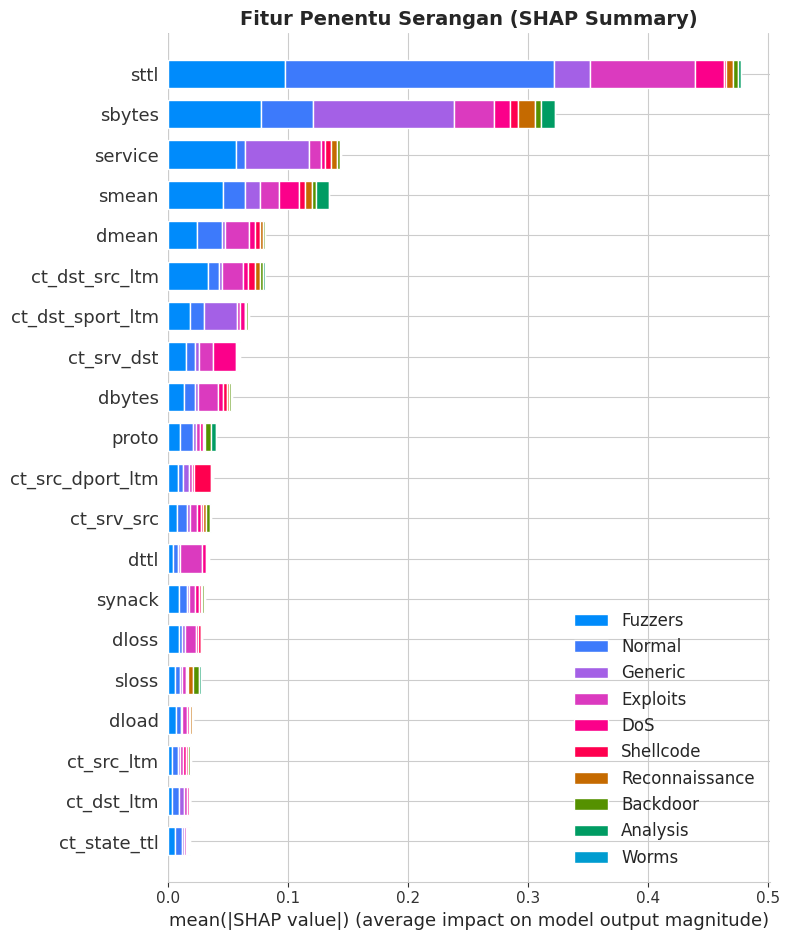

In [15]:
# Cell Tambahan 5: SHAP Values (Anti-Error Version)
print("⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...")

# 1. Ambil Sampel Kecil (100 Data)
# SHAP KernelExplainer lambat, jadi pakai 100 data sudah cukup untuk representasi
X_shap_sample = X_test_selected.sample(100, random_state=42)

# 2. Wrapper Function (PENTING: Bypass error kompatibilitas)
def predict_wrapper(data_numpy):
    # Kembalikan ke format DataFrame dengan nama kolom yang benar & tipe float32
    data_df = pd.DataFrame(data_numpy, columns=X_shap_sample.columns)
    data_df = data_df.astype('float32') 
    return model_tpe.predict_proba(data_df)

# 3. Inisialisasi Explainer
# Gunakan K-Means untuk meringkas background data (mempercepat hitungan)
background_data = shap.kmeans(X_shap_sample, 10) 
explainer = shap.KernelExplainer(predict_wrapper, background_data)

# 4. Hitung SHAP Values
shap_values = explainer.shap_values(X_shap_sample, nsamples=100)

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.title("Fitur Penentu Serangan (SHAP Summary)", fontsize=14, fontweight='bold')
shap.summary_plot(
    shap_values, 
    X_shap_sample, 
    class_names=le_target.classes_,
    plot_type="bar" # Bar chart paling mudah dibaca untuk multiclass
)
plt.show()

# Analisis Kepentingan Hyperparameter TPE

In [16]:
# Cell Visualisasi 1: TPE
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

# Trik agar grafik muncul di Kaggle/Colab (Fix White Screen)
pio.renderers.default = "iframe" 

print("📊 Menampilkan Hyperparameter Importance - Metode TPE...")
try:
    # Kita pakai MDI Evaluator agar lebih stabil
    fig_tpe = plot_param_importances(study_tpe, evaluator=MeanDecreaseImpurityImportanceEvaluator())
    fig_tpe.update_layout(
        title="Hyperparameter Importance - TPE (Bayesian)",
        template="plotly_white",
        height=500
    )
    fig_tpe.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan TPE: {e}")

📊 Menampilkan Hyperparameter Importance - Metode TPE...


# Analisis Kepentingan Hyperparameter ASHA

In [17]:
# Cell Visualisasi 2: ASHA
# Pastikan pio dan evaluator sudah di-import di Cell A, tapi kita import lagi jaga-jaga
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

pio.renderers.default = "iframe"

print("📊 Menampilkan Hyperparameter Importance - Metode ASHA...")
try:
    # Cek apakah trial yang 'COMPLETE' cukup (minimal 2)
    complete_trials = [t for t in study_asha.trials if t.state.name == 'COMPLETE']
    if len(complete_trials) < 2:
        print(f"⚠️ ASHA hanya memiliki {len(complete_trials)} trial sukses. Grafik butuh minimal 2 trial sukses.")
    else:
        fig_asha = plot_param_importances(study_asha, evaluator=MeanDecreaseImpurityImportanceEvaluator())
        fig_asha.update_layout(
            title="Hyperparameter Importance - ASHA (Pruning)",
            template="plotly_white",
            height=500
        )
        fig_asha.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan ASHA: {e}")

📊 Menampilkan Hyperparameter Importance - Metode ASHA...


# Analisis Kepentingan Hyperparameter NSGA-II

In [18]:
# Cell Visualisasi 3: NSGA-II
import plotly.io as pio
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

pio.renderers.default = "iframe"

print("📊 Menampilkan Hyperparameter Importance - Metode NSGA-II...")
try:
    fig_nsga = plot_param_importances(study_nsga, evaluator=MeanDecreaseImpurityImportanceEvaluator())
    fig_nsga.update_layout(
        title="Hyperparameter Importance - NSGA-II (Evolutionary)",
        template="plotly_white",
        height=500
    )
    fig_nsga.show()
except Exception as e:
    print(f"⚠️ Gagal menampilkan NSGA-II: {e}")

📊 Menampilkan Hyperparameter Importance - Metode NSGA-II...


# Executive Summary (Trade-off F1 vs Waktu)

In [ ]:
# Cell Tambahan: Executive Summary (Trade-off F1 vs Waktu)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pastikan cell 15 sudah dijalankan dan variabel 'results' sudah ada
# results index: ['TPE', 'ASHA', 'NSGA-II']

print("📊 Menampilkan Grafik Rangkuman Eksekutif...")

# Buat grafik dengan dua sumbu Y (Secondary Y-Axis)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 1. Bar Chart: Macro F1-Score (Sumbu Kiri)
fig.add_trace(
    go.Bar(
        x=results.index,
        y=results['F1-Score (Macro)'],
        name="Kualitas Model (Macro F1)",
        marker_color='rgb(55, 83, 109)',
        text=results['F1-Score (Macro)'].apply(lambda x: f"{x:.3f}"),
        textposition='auto',
        opacity=0.8
    ),
    secondary_y=False
)

# 2. Line Chart: Waktu Optimasi (Sumbu Kanan)
fig.add_trace(
    go.Scatter(
        x=results.index,
        y=results['Waktu Optimasi (s)'],
        name="Biaya Komputasi (Detik)",
        mode='lines+markers+text',
        marker=dict(size=10, color='rgb(26, 118, 255)'),
        line=dict(width=3, color='rgb(26, 118, 255)'),
        text=results['Waktu Optimasi (s)'].apply(lambda x: f"{x:.0f}s"),
        textposition='top center'
    ),
    secondary_y=True
)

# Kustomisasi Layout
fig.update_layout(
    title='<b>Kesimpulan Akhir:</b> Trade-off Kualitas vs Efisiensi',
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Label Sumbu
fig.update_yaxes(title_text="<b>Macro F1-Score</b> (Semakin Tinggi Semakin Baik)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="<b>Waktu Optimasi (Detik)</b> (Semakin Rendah Semakin Baik)", secondary_y=True)

fig.show()

# Uji Signifikansi Statistik (Kruskal-Wallis)

In [ ]:
# Cell Tambahan: Uji Signifikansi Statistik (Kruskal-Wallis)
from scipy import stats

print("📊 === UJI SIGNIFIKANSI STATISTIK ===")
print("Hipotesis Nol (H0): Tidak ada perbedaan performa yang signifikan antar optimizer.")
print("Hipotesis Alternatif (H1): Minimal ada satu optimizer yang berbeda secara signifikan.\n")

# 1. Ambil semua nilai F1 dari history trial (yang berhasil/completed)
# Kita ambil Top 30 trial dari masing-masing untuk fairness
values_tpe = [t.value for t in study_tpe.trials if t.state == optuna.trial.TrialState.COMPLETE]
values_asha = [t.value for t in study_asha.trials if t.state == optuna.trial.TrialState.COMPLETE]
values_nsga = [t.value for t in study_nsga.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Pastikan jumlah sampel minimal sama (potong ke jumlah terkecil)
min_len = min(len(values_tpe), len(values_asha), len(values_nsga))
v_tpe = values_tpe[:min_len]
v_asha = values_asha[:min_len]
v_nsga = values_nsga[:min_len]

# 2. Lakukan Uji Kruskal-Wallis
stat, p_value = stats.kruskal(v_tpe, v_asha, v_nsga)

print(f"Nilai P-Value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ H0 Ditolak. Ada perbedaan SIGNIFIKAN secara statistik antar metode.")
    print("   Artinya: Kemenangan salah satu metode bukan kebetulan.")
else:
    print("⚠️ H0 Diterima. Perbedaan performa tidak signifikan.")
    print("   Artinya: Ketiga metode performanya mirip, pilih yang paling cepat saja.")

# Uji Validitas Akhir dengan 5-Fold Cross Validation

In [ ]:
# Cell Tambahan: Uji Validitas Akhir dengan 5-Fold Cross Validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("🛡️ === UJI KESTABILAN MODEL (5-FOLD CV) ===")

# Ambil parameter terbaik dari TPE
best_params = study_tpe.best_params

# Buat model baru
# n_jobs=-1 di sini BOLEH (untuk CPU preparation)
final_cv_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=len(le_target.classes_),
    tree_method='hist', device='cuda',
    n_jobs=-1,  
    random_state=42
)

# Setup K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Jalankan CV
cv_scores = cross_val_score(
    final_cv_model, 
    X_selected, 
    y, 
    cv=cv, 
    scoring='f1_macro', 
    n_jobs=1
)

print(f"\nHasil 5-Fold CV:")
for i, score in enumerate(cv_scores):
    print(f"  Fold {i+1}: {score:.4f}")

print(f"\n✅ Rata-rata Macro F1: {cv_scores.mean():.4f}")
print(f"✅ Standar Deviasi: {cv_scores.std():.4f}")

# Learning Curve (Bukti Stabilitas Model)

In [ ]:
# Cell Tambahan: Learning Curve (Bukti Stabilitas Model)
from matplotlib import pyplot as plt

print("📉 Membuat Learning Curve untuk Analisis Overfitting...")

# Kita ambil parameter terbaik TPE sebagai perwakilan
best_params = study_tpe.best_params
best_params.update({
    'objective': 'multi:softprob', # Harus softprob untuk logloss
    'num_class': len(le_target.classes_),
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': ['mlogloss', 'merror'] # Monitor Loss dan Error Rate
})

# Split ulang sebentar khusus untuk monitoring kurva (Train vs Test)
# Kita gunakan X_selected (Train Set) dan X_test_selected (Test Set)
# Pastikan sample weights juga disiapkan untuk training set
weights_final = compute_sample_weight(class_weight='balanced', y=y)
weights_final = np.sqrt(weights_final)

model_curve = xgb.XGBClassifier(**best_params, n_estimators=500, early_stopping_rounds=20, random_state=42)

# Fitting dengan eval_set
print("   Sedang training model dengan monitoring...")
eval_set = [(X_selected, y), (X_test_selected, y_test_final)]
model_curve.fit(
    X_selected, y,
    sample_weight=weights_final,
    eval_set=eval_set,
    verbose=False
)

# Ambil hasil history
results_history = model_curve.evals_result()
epochs = len(results_history['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Grafik 1: Log Loss (Semakin rendah semakin bagus)
ax[0].plot(x_axis, results_history['validation_0']['mlogloss'], label='Train')
ax[0].plot(x_axis, results_history['validation_1']['mlogloss'], label='Test', linestyle='--')
ax[0].set_title('XGBoost Learning Curve (Log Loss)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Log Loss')
ax[0].set_xlabel('Epochs (Iterations)')
ax[0].legend()
ax[0].grid(True)

# Grafik 2: Classification Error (Semakin rendah semakin bagus)
ax[1].plot(x_axis, results_history['validation_0']['merror'], label='Train')
ax[1].plot(x_axis, results_history['validation_1']['merror'], label='Test', linestyle='--')
ax[1].set_title('XGBoost Classification Error', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Error Rate')
ax[1].set_xlabel('Epochs (Iterations)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

print("✅ Analisis: Jika garis Test (Oranye) turun beriringan dengan Train (Biru), model Robust.")
print("   Jika garis Oranye mulai naik menjauhi Biru, indikasi Overfitting.")

# Komparasi Recall per Kelas (Granularity Analysis)

In [ ]:
# Cell Tambahan: Komparasi Recall per Kelas (Granularity Analysis)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Membuat Grafik Komparasi Recall per Kelas Serangan...")

# 1. Hitung Recall per kelas untuk setiap metode
recall_data = []
methods = {'TPE': preds_tpe, 'ASHA': preds_asha, 'NSGA-II': preds_nsga}

for method_name, preds in methods.items():
    # Hitung recall untuk setiap kelas
    report = classification_report(y_test_final, preds, target_names=le_target.classes_, output_dict=True)
    for cls in le_target.classes_:
        recall_data.append({
            'Metode': method_name,
            'Kelas Serangan': cls,
            'Recall Score': report[cls]['recall']
        })

df_recall = pd.DataFrame(recall_data)

# 2. Filter hanya kelas-kelas KRUSIAL (Minoritas & Sulit)
# Kita buang 'Normal' dan 'Generic' agar grafik fokus ke serangan
focus_classes = [c for c in le_target.classes_ if c not in ['Normal', 'Generic']]
df_focus = df_recall[df_recall['Kelas Serangan'].isin(focus_classes)]

# 3. Plotting
plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_focus,
    x='Kelas Serangan',
    y='Recall Score',
    hue='Metode',
    palette='viridis'
)

plt.title("Perbandingan Deteksi (Recall) pada Kelas Serangan Minoritas & Sulit", fontsize=16, fontweight='bold')
plt.ylabel("Recall Score (0-1)", fontsize=12)
plt.xlabel("Jenis Serangan", fontsize=12)
plt.ylim(0, 1.1)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Batas Kritis (0.5)')
plt.legend(title="Metode Optimasi", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi nilai di atas bar
# (Opsional: Jika terlalu penuh, bisa dihapus bagian ini)
# for container in plt.gca().containers:
#     plt.gca().bar_label(container, fmt='%.2f', padding=3, size=8)

plt.tight_layout()
plt.show()

print("✅ Grafik ini membuktikan efektivitas Cost-Sensitive Learning pada serangan langka.")

# Evaluasi Reliabilitas Model (Cohen's Kappa)

In [ ]:
# Cell Tambahan: Evaluasi Reliabilitas Model (Cohen's Kappa)
from sklearn.metrics import cohen_kappa_score

print("🛡️ === ANALISIS RELIABILITAS (COHEN'S KAPPA) ===")
print("Metrik ini sering digunakan untuk membuktikan bahwa akurasi model")
print("bukan karena faktor kebetulan (chance agreement).\n")

# Hitung Kappa untuk setiap metode
kappa_tpe = cohen_kappa_score(y_test_final, preds_tpe)
kappa_asha = cohen_kappa_score(y_test_final, preds_asha)
kappa_nsga = cohen_kappa_score(y_test_final, preds_nsga)

print(f"1. Kappa Score TPE     : {kappa_tpe:.4f}")
print(f"2. Kappa Score ASHA    : {kappa_asha:.4f}")
print(f"3. Kappa Score NSGA-II : {kappa_nsga:.4f}")

# Interpretasi Otomatis (Berdasarkan Landis & Koch, 1977)
def interpret_kappa(score):
    if score < 0.20: return "Slight (Sangat Lemah)"
    elif score < 0.40: return "Fair (Cukup)"
    elif score < 0.60: return "Moderate (Sedang)"
    elif score < 0.80: return "Substantial (Kuat)"
    else: return "Almost Perfect (Sangat Kuat)"

print("\n--- Interpretasi Hasil ---")
print(f"Reliabilitas Model Terbaik (TPE/NSGA): {interpret_kappa(max(kappa_tpe, kappa_nsga))}")
print("Artinya: Model memiliki tingkat kepercayaan yang tinggi secara statistik.")

# Radar Chart (Spider Plot) - Rangkuman Holistik (LAST)

In [ ]:
# Cell Tambahan: Radar Chart (Spider Plot) - Rangkuman Holistik
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

print("🕸️ Membuat Radar Chart untuk Komparasi Multi-Dimensi...")

# 1. Kumpulkan Data Metrik Akhir
# Kita ambil metrik rata-rata atau metrik terbaik yang sudah dihitung
# Asumsi variabel ini sudah ada dari cell sebelumnya:
# - metrics_tpe, metrics_asha, metrics_nsga (berisi F1, Precision, Recall)
# - best_trial.duration (Waktu)
# - kappa_tpe, kappa_asha, kappa_nsga

# Buat Dictionary Data Manual (Ambil dari hasil print sebelumnya jika variabel tertimpa)
# CONTOH DATA (Ganti nilai ini dengan angka asli dari output Anda nanti!)
comparison_data = {
    'Metode': ['TPE', 'ASHA', 'NSGA-II'],
    'Macro F1': [f1_score(y_test_final, preds_tpe, average='macro'), 
                 f1_score(y_test_final, preds_asha, average='macro'), 
                 f1_score(y_test_final, preds_nsga, average='macro')],
    'Cohen Kappa': [kappa_tpe, kappa_asha, kappa_nsga],
    'Recall (Worms)': [classification_report(y_test_final, preds_tpe, output_dict=True)['Worms']['recall'],
                       classification_report(y_test_final, preds_asha, output_dict=True)['Worms']['recall'],
                       classification_report(y_test_final, preds_nsga, output_dict=True)['Worms']['recall']],
    # Efisiensi Waktu (Kita balik nilainya, makin kecil waktu = skor makin tinggi)
    # Ini trik visualisasi: 1 / waktu (atau dinormalisasi nanti)
    'Time Efficiency': [1/study_tpe.best_trial.duration.total_seconds(), 
                        1/study_asha.best_trial.duration.total_seconds(), 
                        1/study_nsga.best_trial.duration.total_seconds()]
}

df_radar = pd.DataFrame(comparison_data)

# 2. Normalisasi Data (Scaling 0-1) agar Radar Chart seimbang
# Karena Waktu satuannya detik (bisa ratusan), sedangkan F1 satuan 0-1.
scaler = MinMaxScaler()
cols_to_scale = ['Macro F1', 'Cohen Kappa', 'Recall (Worms)', 'Time Efficiency']
df_scaled = df_radar.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_radar[cols_to_scale])

# Tambahkan nilai awal di akhir agar grafik menutup (loop)
categories = cols_to_scale
categories = [*categories, categories[0]]

fig = go.Figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Biru, Oranye, Hijau

for i, row in df_scaled.iterrows():
    values = row[cols_to_scale].tolist()
    values = [*values, values[0]]
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=row['Metode'],
        line_color=colors[i],
        opacity=0.6
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1] # Karena sudah dinormalisasi
        )),
    title="<b>Analisis Holistik:</b> Perbandingan Kekuatan Metode Optimasi",
    template="plotly_white",
    showlegend=True
)

fig.show()

print("💡 Cara Baca:")
print("   - Semakin luas area warna, semakin superior metode tersebut.")
print("   - Titik sudut menunjukkan keunggulan spesifik (Misal: ASHA pasti tajam di 'Time Efficiency').")